In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
# import seaborn as sns
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import glob as glob
# import arrow
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
weekly_df = pd.read_csv("dengue-cases.csv",index_col=False)
weekly_df = weekly_df.set_index('date')
weekly_df = weekly_df.iloc[209:]

In [3]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\theta\,(w_{i}\cdot x_{i}) = \frac{1}{1\,+\,e^{-\sum_{i=0}^{n} w_{i} x_{i}}}$$

$$\log cases = \log pop. + \log\,\theta(w\cdot x) \,+\, ...$$

In [117]:
from scipy.special import expit
from scipy.optimize import fmin, minimize

LAG = 26
BETAS_SET = LAG + 1
train = weekly_df.cases[:104]

def theta(w,x):
    pad_x = np.concatenate(([1],np.array(x)))
    score = np.dot(w,pad_x)
    return expit(score)

def guess(w,x):
    return np.log(theta(w,x)+ 1e-5) + np.log(7500.)

def cost(w):
#     return sum((train[i+11] - guess(w,train[i:i+10]))**2 \
#                for i in range(len(train)-11))/len(train)
    ret = 0
    for i in range(len(train)-BETAS_SET):
        real_case = np.log(train[i+BETAS_SET])
        predicted_case = guess(w,train[i:i+LAG])
        ret += (real_case - predicted_case)**2
    print ret/float(len(train))
    return ret/float(len(train))

arr = [0]*BETAS_SET
w = minimize(cost,arr)


0.920115888725
0.920115899587
0.920133071293
0.92013349904
0.920133990144
0.920134233487
0.920134434075
0.920134664466
0.920134811525
0.920134872693
0.920134941487
0.920134976241
0.920134826107
0.920134766896
0.920134508341
0.920134153587
0.920133665018
0.920133506494
0.920133188077
0.920132817734
0.92013249789
0.920132203426
0.920131848314
0.920131442428
0.920130972349
0.920130385311
0.92012988357
0.920129517233
0.920115888725
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.8213657441
71.82136

In [118]:
w.x

array([ -2.22229202e+00,  -3.52210243e-05,   6.22295763e-05,
        -1.89998518e-04,   1.00279485e-05,  -1.14047941e-04,
        -5.58356227e-05,   6.00101545e-05,   8.46576043e-06,
         1.29237302e-04,   1.28064008e-04,  -8.86658439e-05,
        -1.02393602e-04,  -1.74570287e-04,   2.14928196e-04,
         2.24767381e-04,  -3.45688259e-04,  -9.29992758e-05,
         1.48169862e-04,   2.32432377e-04,  -6.03834485e-05,
        -2.09187331e-04,  -8.97466123e-05,  -2.39505436e-04,
         1.33731655e-04,   3.63256437e-04,   5.40239563e-04])

### Naive method in predicting N weeks ahead

In [430]:
NWEEKS = 26
ls_ = []
test = weekly_df.cases[104:]
for i in range(len(test)-NWEEKS):
    res = np.exp(guess(w.x,test[i:i+NWEEKS]))
    ls_.append(res)
    
prediction_26alpha_2week = []
test = weekly_df.cases[104:]
for i in range(len(test)-(NWEEKS+1)):
    
    first_prediction = np.exp(guess(w.x,test[i:i+NWEEKS]))
    arr = np.append(test[i+1:i+NWEEKS],first_prediction)
    
    res = np.exp(guess(w.x,arr))
    prediction_26alpha_2week.append(res)

prediction_4week = []
test = np.array(weekly_df.cases[104:])
for i in range(len(test)-(NWEEKS+3)):
    
    first_prediction = np.exp(guess(w.x,test[i:i+NWEEKS]))
    first_arr = np.append(test[i+1:i+(NWEEKS)],first_prediction)
    
    second_prediction = np.exp(guess(w.x,first_arr))
    second_arr = np.append(first_arr[1:],second_prediction)
    
    third_prediction = np.exp(guess(w.x,second_arr))
    third_arr = np.append(second_arr[1:],third_prediction)
    
    res = np.exp(guess(w.x,third_arr))
    prediction_4week.append(res)
    
    
# make_line(27,test,ls_,
#           'Logistic Function with 26 betas: 1 week ahead prediction',
#           "# week","cases")

# make_line(28,test,prediction_26alpha_2week,'Dengue Prediction 26 lags: 2 weeks ahead',"","")

# make_line(30,test,prediction_4week,
#           'Logistic Function with 26 betas: 1 month ahead prediction',
#           "# week after 2008","cases")

### Upgraded method in predicting N weeks ahead

In [431]:
# predict n amount of week ahead
# based on w.x from the training of betas
# array_x is the initial set of cases to 
# be calculated for the future case
# f'n return the future case from the inclusion
# of the already predicted cases
def n_week_ahead(array_x,weeks_ahead):
    
    theta = 0
    arr = np.array(array_x)
    for i in range(weeks_ahead):
        # exponentiate the log case back
        theta = np.exp(guess(w.x,arr))
        arr = np.append(arr[1:],theta)
    return theta


# tmp = []
# for i in range(len(test)-(NWEEKS+1)): # 1 less the amt of n_week_prediction
#     initial_arr = test[i:i+NWEEKS]
#     tmp.append(n_week_ahead(initial_arr,2)) # 2 weeks ahead prediction


### Graphs of 1, 2, 4, 8 and 12 weeks prediction

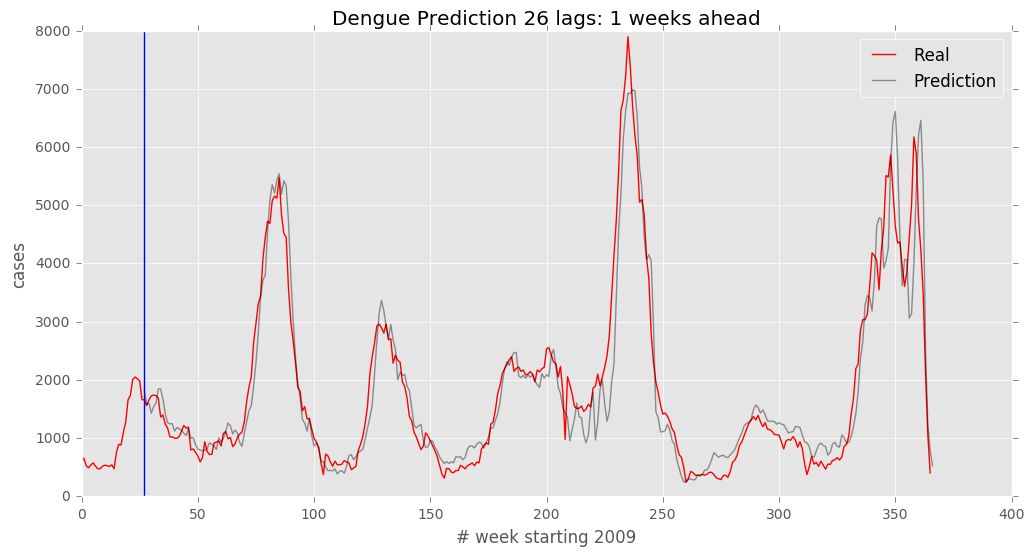

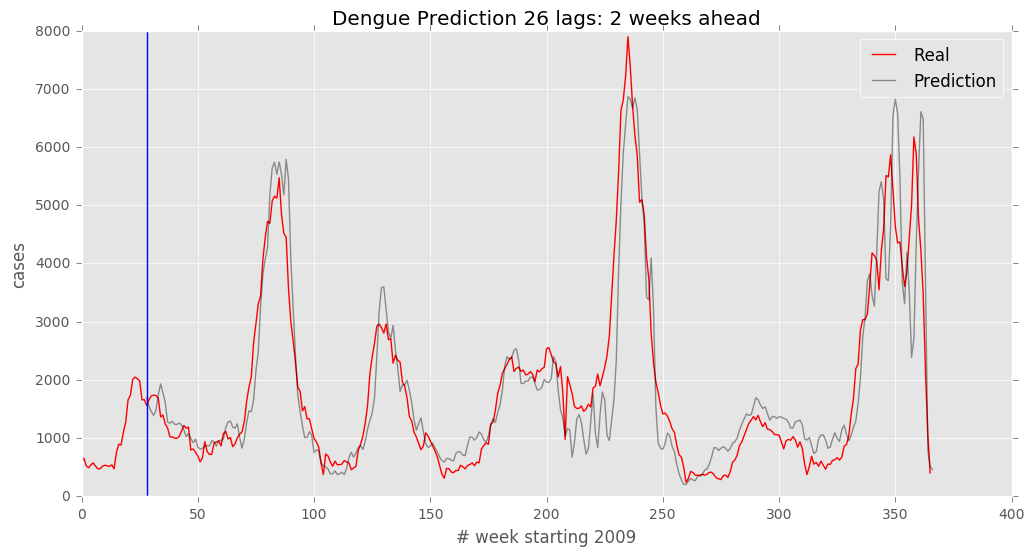

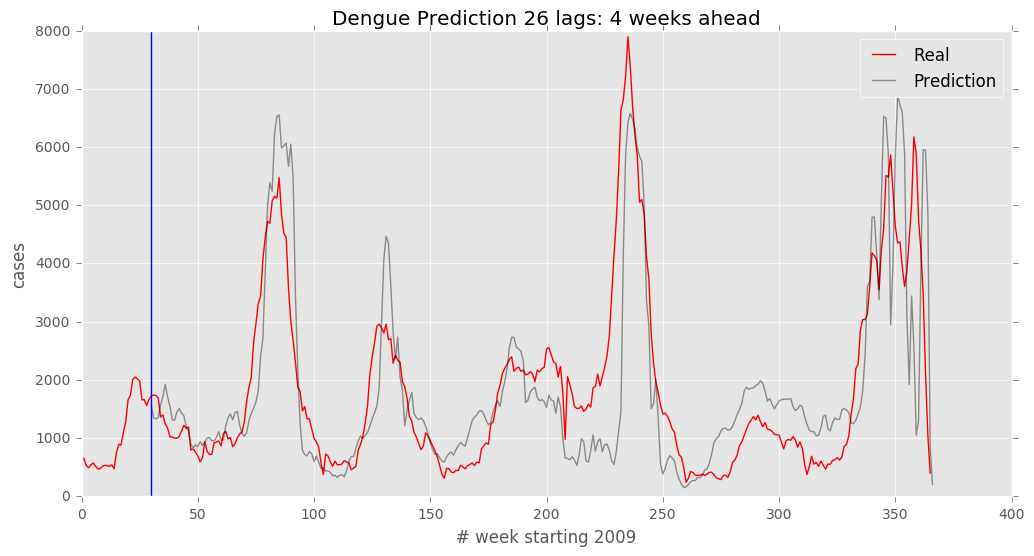

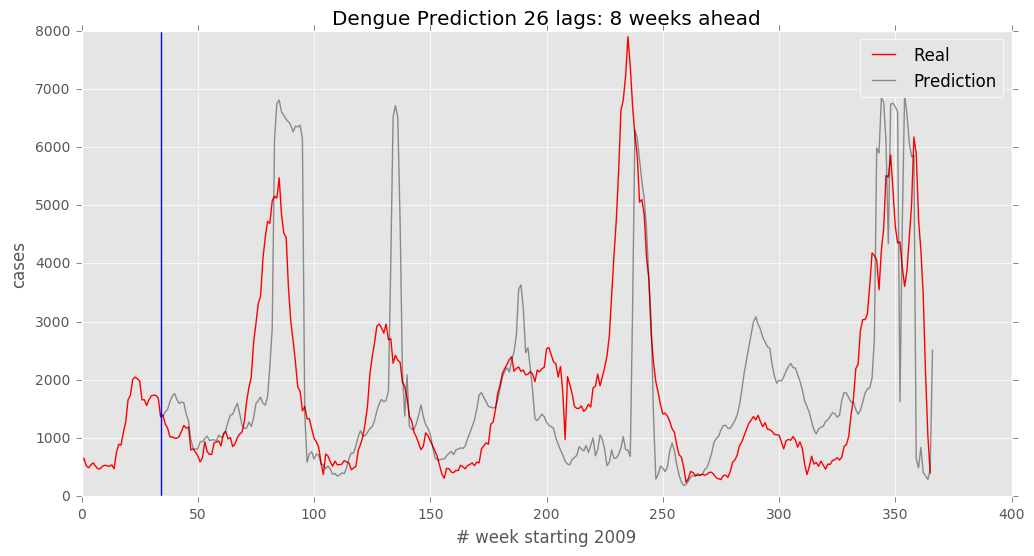

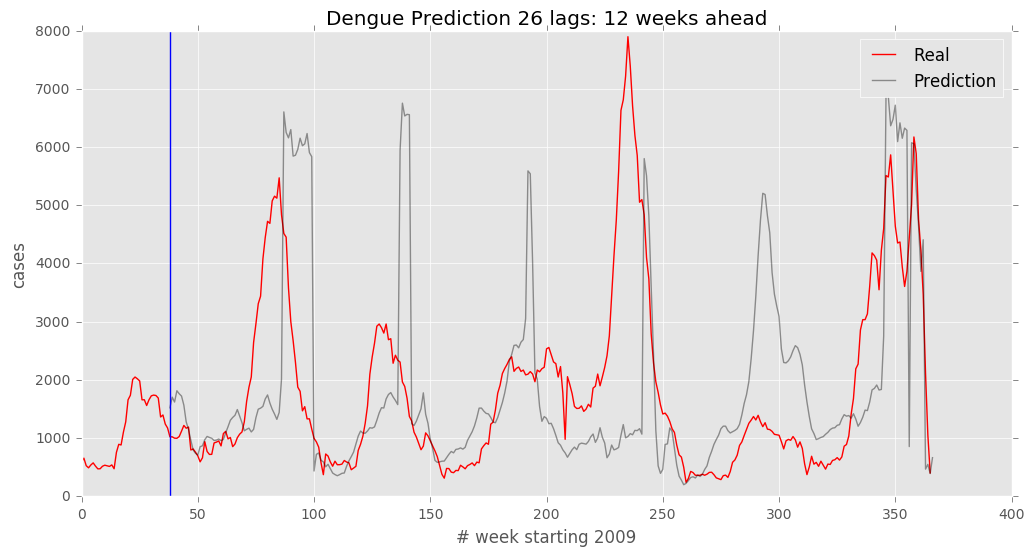

In [437]:
nweek_to_predict = [1,2,4,8,12]

test = weekly_df.cases[104:]
for i in nweek_to_predict:
    N = NWEEKS + (i - 1)
    tmp = []
    for j in range(len(test)-N):
        initial_arr = test[j:j+NWEEKS]
        tmp.append(n_week_ahead(initial_arr,i)) 
    
    title = 'Dengue Prediction 26 lags: %d weeks ahead'%i
    make_line(NWEEKS+i,test,tmp,title,"# week starting 2009","cases")
        


- training data should be 50% of available data
    - this means use dengue cases from beginning of 2007 to end of 2010
    
    
- accuracy of model clearly drops from 1 month and beyond


- two way to fix it is either weather or week number

In [453]:
weekly_df.index = pd.DatetimeIndex(weekly_df.index)

Object `weekly_df.date_range` not found.


In [457]:
mask = (weekly_df.index > "2006") & (weekly_df.index <= "2011")

In [460]:
weekly_df.loc[mask]

,cases
date,
2007-01-07,542
2007-01-14,488
2007-01-21,462
2007-01-28,444
2007-02-04,374
2007-02-11,321
2007-02-18,354
2007-02-25,356
2007-03-04,421
